In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1600,
        'height': 900,
        'scroll': True,
    "theme": "white",
   "transition": "fade",
});
cm.update('rise', {
        'width': 1600,
        'height': 900,
        'scroll': True,
    "theme": "white",
   "transition": "fade",
});

# <center>Course 02463 - Active Machine Learning and Agency
### <center>Bayesian Optimization - Acquisition Functions
<center>Spring 2021, Kristoffer H. Madsen
    
<center>
<br><br>
    <table style="border:none;border-collapse: collapse;border-style:hidden;background-color:#FFFFFF;border-spacing:0;margin=0;padding:0;cellspacing:0;cellpadding:0">
<tr style="background-color:#FFFFFF; border:none; borderstyle:hidden; border-bottom:none">
<th  style="text-align:center">Associate Professor</th><th>  </th>
<th style="text-align:center">Senior Researcher</th>
</tr>
        <tr style="background-color:#FFFFFF; border:none; borderstyle:hidden; border-bottom:none">
<th style="text-align:center">Section for Cognitive Systems</th><th> </th>
<th style="text-align:center">Computational Neuroimaging Group</th>
</tr>
    <tr style="background-color:#FFFFFF; border:none; borderstyle:hidden; border-bottom:none">
<th style="text-align:center">Department of Applied Mathematics and computer Science</th><th> </th>
<th style="text-align:center">Danish Research Centre for Magnetic Resonance</th>
</tr>
    <tr style="background-color:#FFFFFF">
<th style="text-align:center">Technical University of Denmark</th><th></th>
<th style="text-align:center">Copenhagen University Hospital Hvidovre</th>
</tr>
        <tr style="background-color:#FFFFFF">
<th style="text-align:center">khma@dtu.dk</th><th></th>
<th style="text-align:center">kristofferm@drcmr.dk</th>
</tr>
            <tr style="background-color:#FFFFFF">
<th style="text-align:center"><center><img src=imgs/dtu.png width=70></center></th><th>  </th>
<th style="text-align:center"><center><img src=imgs/DRCMR.png width=210></center></th>
</tr>
</table>
    </center>

# Objectives in Bayesian optimization
- Find the <b>global</b> optimum (global optimization procedure)
- Optimization of non-convex and stochastic functions
- Used when the cost function is expensive to evaluate
- Balance between exploitation and exploration

# Bayesian optimization - simple example
## www.brain-fmri.com/BO

# How?
## Key elements
- Model
- Data
- Objective function

# How?
## Key tools
- Uncertainty quantification
    - Most algorithm that you worked on until now just give a point estimate
    - It will be important to quantify what we are uncertain about in order to "ask" relevant follow-up questions
- Probabilistic modeling (Bayes)
    - A way to archive the above
- Prediction of what a future experiment might bring using the current model
    - Evaluate expected knowledge (with respect to some objective) that is given by a new data point/experiment

# Bayesian optimization procedure
- Acquire initial points
- For each iteration
    - Fit function with uncertainty quantification in practice often a GP
    - Optimize kernel parameters
    - Calculate acquisition function across feasible input space
    - Select best point
    - Evaluate function at this point

# GP demo
- Press key 'o' to optimize kernel parameters according to training likelihood
- Press key 'c' to sample 5 lines from the posterior density

<IPython.core.display.Javascript object>


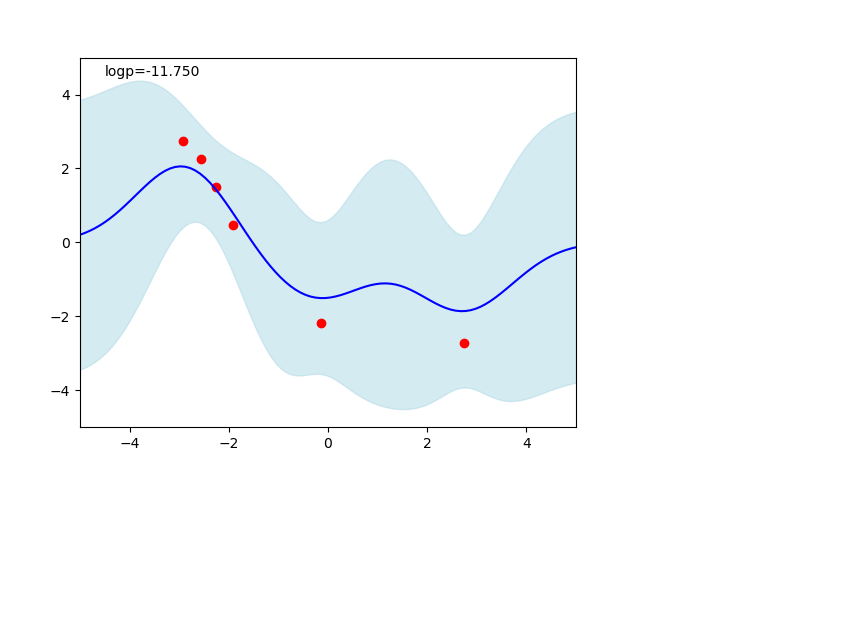

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='sigma', max=10.0, min=0.001…

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='l', max=10.0, min=0.001, st…

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='sigma_n', max=10.0, min=0.0…

interactive(children=(Dropdown(description='Kernel', options=(('squared exponential', <function squared_expone…

interactive(children=(Checkbox(value=False, description='Auto optimize kernel parameters'), Output()), _dom_cl…

In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure('GP regression');
ax = fig.add_subplot(111);
global step
step = 0
import torch as t
from ipywidgets import interact
import scipy.optimize

## kernel definition
def squared_exponential_kernel(a, b, lengthscale, variance):
    """ GP squared exponential kernel """
    # compute the pairwise distance between all the point
    # sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqdist = (a**2).sum(1)[:,None] + (b**2).sum(1) - 2 * a@b.transpose(1,0)
    return variance * np.e**(-.5 * (1/lengthscale**2) * sqdist)
    # return variance * np.exp(-.5 * (1/lengthscale**2) * sqdist)

def matern52(a, b, lengthscale, variance):
    #C_{5/2}(d) = \sigma^2\left(1+\frac{\sqrt{5}d}{\rho}+\frac{5d^2}{3\rho^2}\right)\exp\left(-\frac{\sqrt{5}d}{\rho}\right)
    # compute the pairwise distance between all the point
    # d2 = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    d2 = (a**2).sum(1)[:,None] + (b**2).sum(1) - 2 * a@b.transpose(1,0)
    return variance * (1 + np.sqrt(5.)*d2**(0.5)/lengthscale + 5*d2/(3 * lengthscale**2)) * np.e**(-np.sqrt(5.)*d2**0.5/lengthscale)

kernel = matern52
autoopt = False

def fit_GP(X, y, Xtest, kernel, lengthscale, kernel_variance, noise_variance, period=1):
    ## we should standardize the data
    X = np.array(X).reshape(-1, 1)
    y = np.array(y)
    K = kernel(X, X, lengthscale, kernel_variance)
    L = np.linalg.cholesky(K + noise_variance * np.eye(len(X)))

    # compute the mean at our test points.
    Ks = kernel(X, Xtest, lengthscale, kernel_variance)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))  #
    mu = Ks.T @ alpha

    v = np.linalg.solve(L, Ks)
    # compute the variance at our test points.
    Kss = kernel(Xtest, Xtest, lengthscale, kernel_variance)
    # s2 = np.diag(K_) - np.sum(Lk ** 2, axis=0)
    covariance = Kss - (v.T @ v)
    # s = np.sqrt(s2)
    return mu, covariance

def loglike(X,y,kernel,lengthscale, kernel_variance, noise_variance):
    #this is not a recommended way of calculating the likelihood from an efficiency point of view
    X = t.from_numpy(np.array(X).reshape(-1, 1))
    y = t.from_numpy(np.array(y).reshape(-1, 1))
    K = kernel(X, X, lengthscale, kernel_variance) + noise_variance * t.eye(len(X),dtype=t.float64)
    return -.5 * y.transpose(1,0)@t.inverse(K)@y - 0.5*t.logdet(K)- .5 * len(X) * np.log(2*np.pi)
    #the below would be better from a stability point of view
    #but the autograd for cholesky seems to be broken at least in pytorch 1.6 
    #L = t.cholesky(K)
    #alpha = t.cholesky_solve(t.cholesky_solve(y,L),L.transpose(1,0))
    #return -.5 * y.transpose(1,0)@alpha - .5 * t.sum(t.diag(L)) - .5 * len(X) * np.log(2*np.pi)

global lengthscale, kernel_variance, noise_var
## parameters definition
lengthscale = 1 # determines the lengths of the wiggle
kernel_variance = 1 # scale factor
noise_var = .2
n_test_point = 100
n_samples = 10
Xtrain = []
ytrain = []
Xtest = np.linspace(-5, 5, n_test_point).reshape(-1,1)

def on_sample(event):
    if event.key=='c':
        global step, lengthscale, kernel_variance, noise_var
        ## we want the mean + the std deviation but also some samples from the posterior
        # clear frame
        plt.clf()
        # we have to refit the GP
        mu, covariance = fit_GP(Xtrain, ytrain, Xtest, kernel, lengthscale, kernel_variance, noise_var)
        # we should get the var
        var = np.sqrt(np.diag(covariance))
        # and we have to sample for it
        samples = np.random.multivariate_normal(mu.reshape(-1), covariance, n_samples)  # SxM
        plt.plot(Xtrain, ytrain, 'ro')
        plt.gca().fill_between(Xtest.flat, mu - 3 * var, mu + 3 * var, color='lightblue', alpha=0.5)
        plt.plot(Xtest, mu, 'red')
        for sample_id in range(n_samples):
            plt.plot(Xtest, samples[sample_id])
        plt.axis([-5, 5, -5, 5])
        plt.draw()  # redraw
    elif event.key=='x':
        optim_hp2()
    elif event.key=='v':
        optim_hp3()
    elif event.key=='o':
        optim_hp()

def on_click1(event):
    global lengthscale, kernel_variance, noise_var, autoopt
    if not event.xdata is None and not event.ydata is None:
        global step
        Xtrain.append(event.xdata)
        ytrain.append(event.ydata)
        if autoopt:
            optim_hp()
        step += 1
        # we have to refit the GP
        redraw()

def redraw():
    global lengthscale, kernel_variance, noise_var
    mu, covariance = fit_GP(Xtrain, ytrain, Xtest, kernel, lengthscale, kernel_variance, noise_var)
    var = np.sqrt(np.diag(covariance))
    plt.clf()
    plt.plot(Xtrain, ytrain, 'ro')
    plt.gca().fill_between(Xtest.flat, mu - 3 * var, mu + 3 * var,  color='lightblue', alpha=0.5)
    plt.plot(Xtest, mu, 'blue')
    plt.axis([-5, 5, -5, 5])
    if len(Xtrain)>0:
        plt.text(-4.5,4.5,'logp=%.3f'%loglike(Xtrain,ytrain,kernel,lengthscale, kernel_variance, noise_var))
    plt.draw() #redraw

def optim_hp():
    global lengthscale, kernel_variance, noise_var
    kpar = [t.autograd.Variable(t.tensor(i,dtype=t.float64),requires_grad=True) for i in (lengthscale, kernel_variance, noise_var)]
    opt = t.optim.LBFGS(kpar,lr=0.1,line_search_fn='strong_wolfe')
    
    def closure():
        loss = -loglike(Xtrain,ytrain,kernel,t.abs(kpar[0]),t.abs(kpar[1]),t.abs(kpar[2]))
        opt.zero_grad()
        loss.backward()
        return loss
    for i in range(10):
        opt.step(closure)
    lengthscale = np.abs(kpar[0].item())
    kernel_variance = np.abs(kpar[1].item())
    noise_var = np.abs(kpar[2].item())+np.spacing(1)
    #print(loglike(Xtrain,ytrain,kernel,lengthscale, kernel_variance, noise_var))
    #print((lengthscale, kernel_variance, noise_var))
    #redraw()
    widg1.children[0].value=kernel_variance
    widg2.children[0].value=lengthscale
    widg3.children[0].value=noise_var

def ll2(x):
    kpar = [t.autograd.Variable(t.tensor(i,dtype=t.float64),requires_grad=True) for i in x]
    loss = -loglike(Xtrain,ytrain,kernel,t.abs(kpar[0]),t.abs(kpar[1]),t.abs(kpar[2]))
    loss.backward()
    g=np.zeros(len(kpar))
    for i,k in enumerate(kpar):
        g[i] = k.grad.item()
    return (loss.item(),g)

def optim_hp2():
    global lengthscale, kernel_variance, noise_var
    ll=lambda kpar: -loglike(Xtrain,ytrain,kernel,np.abs(kpar[0]),np.abs(kpar[1]),np.abs(kpar[2]))[0][0]
    print(np.array((lengthscale, kernel_variance, noise_var)))
    res=scipy.optimize.minimize(ll2,np.array((lengthscale, kernel_variance, noise_var)),jac=True)
    kpar=res.x
    print(res.x)
    lengthscale = np.abs(kpar[0])
    kernel_variance = np.abs(kpar[1])
    noise_var = np.abs(kpar[2])+np.spacing(1)
    #redraw()
    widg1.children[0].value=kernel_variance
    widg2.children[0].value=lengthscale
    widg3.children[0].value=noise_var
    
def optim_hp3():
    global lengthscale, kernel_variance, noise_var
    ll=lambda kpar: -loglike(Xtrain,ytrain,kernel,np.abs(kpar[0]),np.abs(kpar[1]),np.abs(kpar[2]))[0][0]
    res=scipy.optimize.minimize(ll,np.array((lengthscale, kernel_variance, noise_var)))
    kpar=res.x
    lengthscale = np.abs(kpar[0])
    kernel_variance = np.abs(kpar[1])
    noise_var = np.abs(kpar[2])+np.spacing(1)
    #redraw()
    widg1.children[0].value=kernel_variance
    widg2.children[0].value=lengthscale
    widg3.children[0].value=noise_var
    
mu, covariance = fit_GP(Xtrain, ytrain, Xtest, kernel, lengthscale, kernel_variance, noise_var)
var = np.sqrt(np.diag(covariance))

plt.plot(Xtrain, ytrain, 'ro');
plt.gca().fill_between(Xtest.flat, mu - 3 * var, mu + 3 * var,  color='lightblue', alpha=0.5);
plt.plot(Xtest, mu, 'blue')
plt.axis([-5, 5, -5, 5])
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
from ipywidgets import Dropdown
from ipywidgets import Checkbox
from IPython.display import display
sliders=[FloatSlider(value=1.,min=0.001, max=10., step=.01,continuous_update=False) for i in range(3)]
sliders[2].value=0.1
kernsel=Dropdown(options=[('squared exponential',squared_exponential_kernel),('matern 5/2',matern52)],value=squared_exponential_kernel)
auto_opt_sel=Checkbox(value=False,description='Auto optimize kernel parameters')

def update1(sigma):
    global lengthscale, kernel_variance, noise_var
    kernel_variance=sigma
    redraw()
    
def update2(l):
    global lengthscale, kernel_variance, noise_var
    lengthscale=l
    redraw()
    
def update3(sigma_n):
    global lengthscale, kernel_variance, noise_var
    noise_var=sigma_n
    redraw()
def update4(Kernel):
    global kernel
    kernel = Kernel
    if autoopt:
        optim_hp()
    redraw()
def update5(auto_opt):
    global autoopt
    autoopt = auto_opt
    if autoopt:
        optim_hp()
    redraw()
    
widg1=interactive(update1,sigma=sliders[0])
widg2=interactive(update2,l=sliders[1])
widg3=interactive(update3,sigma_n=sliders[2])
widg4=interactive(update4,Kernel=kernsel)
widg5=interactive(update5,auto_opt=auto_opt_sel)

fig.canvas.mpl_connect('button_press_event',on_click1)
fig.canvas.mpl_connect('key_press_event',on_sample)
display(widg1);
display(widg2);
display(widg3);
display(widg4);
display(widg5);

# Acquisition functions 
- A function that we can evaluate (quicker that the objective function itself) to determine the "value" of evaluating that point
- Should take into account the uncertainty of the function
- Typically has a free parameter that trades of exploitation/exploration

# Probability of improvement
- The probability that the objective is above the current best value
$$\text{PI}(\mathbf{x}) = \text{P}(f(\mathbf{x}) \geq f(\mathbf{x}^+))$$
- Using properties of the Gaussian distribution this is easy, but requires evaluation of the cumulative distribution function
    - This so-called error function has no easy analytical form but is provided in almost any software package
    $$\Phi(z) := \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{z} e^{-\frac{1}{2}u^2} du$$
- So if we standardize the estimated objective we have
$$\begin{align}
\label{eq:our_PI}
\begin{split}
\text{PI}(\mathbf{x}) &= \text{P}(f(\mathbf{x}) \geq f(\mathbf{x}^+) + \xi) = \\
               &= \Phi\biggl(\frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi}{\sigma(\mathbf{x})}\biggr)
\end{split}
\end{align}$$


<img src="imgs/PI.png">

# Expected improvement
- Instead of working with the probability this functions tries to quantify the expected improvement
- Here we denote the improvement $\text{I}(\mathbf{x})$:
$$\text{I}(\mathbf{x}) = \max \{0, f_{t+1}(\mathbf{x}) - f(\mathbf{x}^+)\}$$
- And take the expected value of this improvement
    - Scale a $\mathcal N(0,1)$ variable with the variance and add the mean function, then manipulate the expression to get the expectation
\begin{align}
\begin{split}
\text{EI}(\mathbf{x}) = \left\{
\begin{array}{>{\displaystyle\tallstrut}l@{}}
(\mu(\mathbf{x}) - f(\mathbf{x}^+)) \Phi(Z) + \sigma(\mathbf{x})  \phi(Z) \hspace{1.66cm} & \text{if } \sigma(\mathbf{x}) > 0\\ 
0  \hspace{6.5cm} & \text{if } \sigma(\mathbf{x}) \leq 0
\end{array}
\right.
\end{split}
\end{align}
where $$Z = \frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi }{\sigma(\mathbf{x})}$$
and $\xi$ is a parameter to control the exploitation/exploration tradeoff. $\phi$ is the Normal density function.

# Upper confidence bound
- Directly use the maximum value that we might expect
- Original formulation just use the mean and add "some" standard deviations to it
\begin{align}
\begin{split}
\text{UCB}(\mathbf{x}) = \mu(\mathbf{x}) + \kappa \sigma (\mathbf{x})
\end{split}
\end{align}
- The expression below will ensure asymptotic zero regret - that is it should eventually converge to the correct solution. 
\begin{align}
\begin{split}
\text{GP-UCB}(\mathbf{x}) = \mu(\mathbf{x}) + \sqrt{\nu \beta_t} \sigma (\mathbf{x})
\end{split}
\end{align}
with $\nu=1$ and $\beta_t = 2 \log(\frac{t^{\frac{d}{2}+2}\pi^2}{3 \delta})$
 where $t$ is the iteration number, $d$ is the dimensionality of the problem, and $\delta \in (0,1)$

# Different acquisition functions
<img src="imgs/Acqs1.png">

<img src="imgs/Acqs2.png">
Illustrations shamelessly stolen from: "A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning" by Eric Brochu, Vlad M. Cora and Nando de Freitas, 2010, Arxiv

# Discrete and categorical variables
- Discrete variables are typically just modeled as continuous, variables are restricted to allowed values, that is we ignore

- Categorical variables are more problematic a common approach is to use one-out-of-K encoding
    - Assumes that effect of each label is continuous, when in reality the evaluation possibilities typically very few
    - Increases the dimensionality and hence the complexity of search and very flat regions of the acquisition function may occur
    
Still most software implementations, such as GPyOpt uses one-out-of-K encoding

# Summery
## Ingredients for Bayesian optimization
- Probabilistic model for observations
    - GP
    - Optimization of kernel parameters
- Acquisition function
    - Formulate and define parameters, typically a exploration weight
    - Optimize and suggest next point

# Additional notes and limitations
- The squared exponential kernel is often considered too smooth
- Optimization of kernel hyperparameters can be unstable, integrating over them can provide better stability
- Optimization is sequential with limited possibility of parallelization
- Scalability to high dimensionality large number of observations is somewhat limited
- It all about the prior: Having the wrong covariance structure can lead to very bad performance
- In general no guarantees for converge or better performance than random search
- Unclear how to set exploration parameter

# Practical implementations
As you have experienced in the exercise there is actually not that much to implementing your own Bayesian optimization algorithm
## However, it can be tedious to:
- Implementing various kernels and derivatives efficently
- Optimizing hyperparameters in a stable way
- Implementing Acquisition functions
- Optimizing acqusition functions
- Making the code robust
- Scaling Gaussuan process regression to high dimensionality

In the following slides some examples using existing software packages for Python is given

# GPyOpt
GPyOpt is a Python package that implements Bayesian optimization from University of Sheffield ML group
- Relies on GPy to fit Gaussian processes
- Implements the three acquisition functions we considered
- Documentation is somewhat lacking
- Can optimize over continuous, discrete and categorical variables within bounds also referred to as mixed domain optimization

# Minimal example
- Minimize function $f(x,y)$ (with initial points $x_0$ given)
<code>
    import GPyOpt 
    bounds2d = [{'name': 'x', 'type': 'continuous', 'domain': (-3,3)},
                {'name': 'y', 'type': 'continuous', 'domain': (-3,3)}]    
    bo = GPyOpt.methods.BayesianOptimization(f, domain=bounds2d, X=x0, acquisition_type='EI')    
    bo.run_optimization(max_iter = niter)
</code>

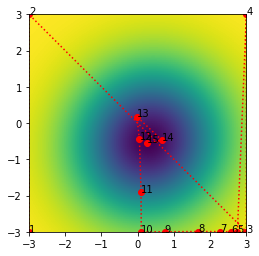

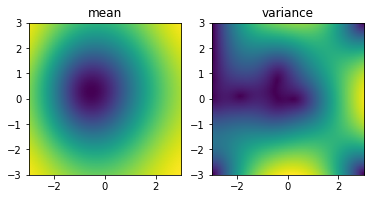

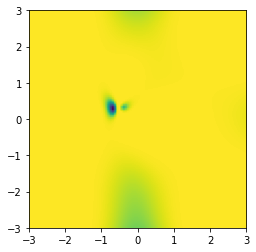

In [1]:
# Define function
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
normal = multivariate_normal(mean=[0.3,-0.5], cov=[[2,.1],[.1,2]])
f= lambda x: -normal.pdf(x)
N = 100
x = np.linspace(-3,3,N)
x = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1)
Xinit = np.array([[-3,-3],[-3,3],[3,-3],[3,3]])

#GPyOpt
import GPyOpt
bounds2d = [{'name': 'x', 'type': 'continuous', 'domain': (-3,3)},
            {'name': 'y', 'type': 'continuous', 'domain': (-3,3)}]

bo = GPyOpt.methods.BayesianOptimization(f, domain=bounds2d, X=Xinit, acquisition_type='EI',exact_feval=True)
bo.run_optimization(max_iter = 11)

#Plotting
y=f(x.T).reshape(N,N).T
plt.figure('Optimization progress')
plt.imshow(y,cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);
plt.plot(bo.X[:,0],bo.X[:,1],'ro:')
for i,xx in enumerate(bo.X):
    plt.text(xx[0],xx[1],'%i'%(i+1))
plt.figure('Approximated function')
plt.subplot(1,2,1)
plt.title('mean')
plt.imshow(bo.model.predict(x.T)[0].reshape(N,N),cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);
plt.subplot(1,2,2)
plt.title('variance')
plt.imshow(bo.model.predict(x.T)[1].reshape(N,N),cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);
#plt.suptitle('Approximated function')
plt.figure('Acquisition function')
plt.imshow(bo.acquisition.acquisition_function(x.T).reshape(N,N),cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);

# GPy extended tips
## Adding a prior on GP kernel parameters in GPyOpt

- For example to improve instability problem of hyper-parameter determination

### Define kernel

Matérn 5/2 with $\Gamma$ distribution prior on lengthscale and variance
$\Gamma$ parametrized by scale and $\text{rate}=\text{shape}^{-1}$
<code>
    import GPy
    k52 = GPy.kern.Matern52(input_dim=2, variance=1, lengthscale=50)
    k52.lengthscale.set_prior(GPy.priors.Gamma.from_EV(100, 1))
    k52.variance.set_prior(GPy.priors.Gamma.from_EV(1.,1.))
</code>

### Use it in the Bayesian optimization call:

<code>
    bopt = GPyOpt.methods.BayesianOptimization(sf, kernel=k, domain=bounds2d)
</code>

# Kernels can be added
Here an example with an extra noise kernel (White kernel):
<code>
    k_noise = GPy.kern.White(input_dim=2)
    kernel = k52+k_noise
</code>

# Kernels can also be multiplied
- Useful if one desire different lenghtscales on different inputs, here we also use the active_dims keyword

For example:
<code>
    k1 = GPy.kern.RBF(input_dim=1, active_dims=[0])
    k2 =  GPy.kern.RBF(input_dim=1, active_dims=[1])
    kernel = k1 * k2
</code>
From this you will effectively get separate variance and lengthscale parameters for the two dimensions.

# Scikits-optimize
<a href=https://scikit-optimize.github.io>https://scikit-optimize.github.io</a>

In [25]:
# example of bayesian optimization with scikit-optimize
import numpy as np
from skopt.space import Integer
import skopt.space
from skopt import gp_minimize
from skopt.utils import use_named_args
search_space = [skopt.space.Real(-3, 3, name='x1'), skopt.space.Real(-3, 3, name='x2')]

@use_named_args(search_space)
def objective(x1,x2):
    return f((x1,x2))

# perform optimization
#result = gp_minimize(f, search_space)
# summarizing finding:
#print('Best Accuracy: %.3f' % (1.0 - result.fun))
#print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

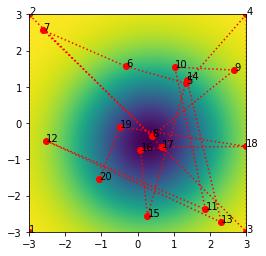

In [36]:
res=gp_minimize(objective, search_space, n_calls=20, x0=[[x0[0],x0[1]] for x0 in Xinit],acq_func='gp_hedge')

y=f(x.T).reshape(N,N).T
plt.figure('Optimization progress')
plt.imshow(y,cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);
plt.plot(np.array(res.x_iters).T[0],np.array(res.x_iters).T[1],'ro:')
for i,xx in enumerate(res.x_iters):
    plt.text(xx[0],xx[1],'%i'%(i+1))



# GP-Hedge
Idea consider several acquisition functions and sample probalistically between them
<img src=imgs/gphedge_algo.png>
From: Hoffman, M., Brochu, E., & De Freitas, N. (2011). Portfolio allocation for Bayesian optimization. Proceedings of the 27th Conference on Uncertainty in Artificial Intelligence, UAI 2011, 327–336. AUAI Press.

## Bayesian-optimization
https://github.com/fmfn/BayesianOptimization
<code>
    from bayes_opt import BayesianOptimization
    # Bounded region of parameter space
    pbounds = {'x1': (-3, 3), 'x2': (-3, 3)}
    optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds)
</code>

# Other BO packages for python
- sigopt (https://app.sigopt.com/docs/overview/python)
- hyperopt (http://hyperopt.github.io/hyperopt/)
- spearmint (https://github.com/HIPS/Spearmint)
- MOE (https://github.com/Yelp/MOE)
- BOTorch (https://botorch.org/)
- DragonFly (https://github.com/dragonfly/dragonfly)